In [1]:
# notebooks/test_real_dem_integration.ipynb

import sys
import os


sys.path.append(os.path.abspath(".."))
import xarray as xr
from scripts.elevation_manager import (
    load_and_subset_dem,
    bin_by_altitude,
    add_alt_to_ds
)
from scripts.subsetting import subset_by_lat_lon, subset_time
from scripts.utils import prepare_reference_grid, prepare_ensemble_grid
from scripts.regridding import regrid_to_target
from scripts.temporal_stats import aggregate_to_daily, aggregate_by_month, aggregate_by_season, aggregate_by_year
from scripts.bias_metrics import mean_error, mean_absolute_error, root_mean_squared_error


# 1. DEM Path and variable
dem_path = "../data/INCA_DEM.nc"
dem_var = "ZH"

# 2. Load + subset DEM
#    For demonstration, we show bounding box & time, but adjust to your domain.
lat_bounds = (48.0, 49.0)
lon_bounds = (11.0, 12.0)
start_date = "2017-10-01"
end_date = "2017-10-02"  # If your DEM has time dimension, or skip time subset if not relevant.

dem_ds = load_and_subset_dem(
    dem_path,
    dem_var=dem_var,
    lat_bounds=lat_bounds,
    lon_bounds=lon_bounds,
    lat_var="lat",   # or "lat" if your DEM stores lat in var named "lat"
    lon_var="lon",   # or "lon"
    dim_lat="y",     # default for your DEM
    dim_lon="x"      # default for your DEM
)


print("DEM dataset after preparation:", dem_ds)




DEM dataset after preparation: <xarray.Dataset> Size: 139kB
Dimensions:                  (lat_coord: 113, lon_coord: 76)
Coordinates:
    lat_dim                  (lat_coord) int32 452B 457000 458000 ... 569000
    lon_dim                  (lon_coord) int32 304B 227000 228000 ... 302000
    lambert_conformal_conic  float64 8B nan
    lat                      (lat_coord, lon_coord) float32 34kB 47.99 ... 49.01
    lon                      (lat_coord, lon_coord) float32 34kB 11.01 ... 11.99
  * lat_coord                (lat_coord) float32 452B 47.99 48.0 ... 48.99 49.0
  * lon_coord                (lon_coord) float32 304B 11.01 11.03 ... 12.02
Data variables:
    altitude                 (lat_coord, lon_coord) float64 69kB nan nan ... nan
Attributes:
    grid_mapping:        lambert_conformal_conic
    Conventions:         CF-1.7
    title:               analysis
    institution:         GeoSphere Austria
    source:              modeled data
    references:          https://www.geospher

In [2]:
from scripts.data_loader import load_nc_files
from scripts.ensemble_loader import load_ensemble_files
# 3. Load your reference dataset (already on the same grid or to be prepared similarly)
ref_path = "../data/SPARTACUS2-DAILY_RR_2017.nc"
ref_ds = load_nc_files(ref_path)
# Possibly do lat/lon/time subsetting:
ref_ds = subset_by_lat_lon(ref_ds, lat_bounds, lon_bounds, lat_var="lat", lon_var="lon")
ref_ds = subset_time(ref_ds, start_date, end_date)
# Then prepare it if needed:
ref_ds_prepared = prepare_reference_grid(ref_ds, lat_var="lat", lon_var="lon", dim_lat="y", dim_lon="x")

# 4. Load your ensemble dataset, regrid it to the reference/DEM grid
ensemble_pattern = os.path.join("../data", "total_precipitation_2017*.nc")
chunks = {'time': 1, 'lat': 100, 'lon': 100}  # Example chunking for large files
ds_ensemble = load_ensemble_files(ensemble_pattern, chunks=None)
# We assume ensemble_ds is already prepared or we do something like:
# ensemble_ds_prepared = prepare_reference_grid(ensemble_ds, ...)
# Then subset lat/lon/time:
ensemble_ds_subset = subset_by_lat_lon(ds_ensemble, lat_bounds, lon_bounds, lat_var="latitude", lon_var="longitude")
ensemble_ds_sub = subset_time(ensemble_ds_subset, start_date, end_date)
print("Ensemble dataset subset:", ensemble_ds_sub)
ensemble_ds_prepared = prepare_ensemble_grid(ensemble_ds_sub, lat_var='latitude', lon_var='longitude')

print("Reference dataset prepared:", ref_ds_prepared)
print("Ensemble dataset prepared:", ensemble_ds_prepared)

ens_ds_interp = regrid_to_target(ensemble_ds_prepared, ref_ds_prepared)
dem_ds = regrid_to_target(dem_ds, ref_ds_prepared)

print("Ensemble dataset on target grid:", ens_ds_interp)
print("Elevation dataset on target grid:", dem_ds)



Ensemble dataset subset: <xarray.Dataset> Size: 15MB
Dimensions:        (time: 48, lat: 56, lon: 36, member: 10)
Coordinates:
  * member         (member) object 80B '00' '01' '02' '03' ... '07' '08' '09'
  * time           (time) datetime64[ns] 384B 2017-10-01 ... 2017-10-02T23:00:00
Dimensions without coordinates: lat, lon
Data variables:
    latitude       (time, lat, lon, member) float32 4MB 48.0 48.0 ... 48.99
    longitude      (time, lat, lon, member) float32 4MB 11.01 11.01 ... 11.99
    precipitation  (time, lat, lon, member) float64 8MB 1.013 1.642 ... 0.02234
Reference dataset prepared: <xarray.Dataset> Size: 208kB
Dimensions:                  (time: 2, lat_coord: 113, lon_coord: 76)
Coordinates:
    lambert_conformal_conic  float64 8B nan
    lat                      (lat_coord, lon_coord) float32 34kB 47.98 ... 49.01
    lon                      (lat_coord, lon_coord) float32 34kB 11.01 ... 11.99
  * time                     (time) datetime64[ns] 16B 2017-10-01 2017-10-02
 

In [3]:
# 5. Attach DEM altitude to ensemble
ensemble_with_alt = add_alt_to_ds(ens_ds_interp, dem_ds)
print("Ensemble dataset with altitude added:", ensemble_with_alt)

ref_with_alt = add_alt_to_ds(ref_ds_prepared, dem_ds)
print("Reference dataset with altitude added:", ref_with_alt)

# 6. Bin by altitude
alt_bins = [0, 500, 1000, 1500, 2000, 3000]
binned_ens = bin_by_altitude(ensemble_with_alt, bins=alt_bins)
for alt_range, ds_bin in binned_ens.items():
    print(f"Altitude bin {alt_range} => shape: {ds_bin.dims}")


binned_ref = bin_by_altitude(ref_with_alt, bins=alt_bins)
for alt_range, ds_bin in binned_ref.items():
    print(f"Altitude bin {alt_range} => shape: {ds_bin.dims}")



Ensemble dataset with altitude added: <xarray.Dataset> Size: 33MB
Dimensions:                  (time: 48, lat_coord: 113, lon_coord: 76,
                              member: 10)
Coordinates:
  * member                   (member) object 80B '00' '01' '02' ... '08' '09'
  * time                     (time) datetime64[ns] 384B 2017-10-01 ... 2017-1...
  * lat_coord                (lat_coord) float32 452B 47.98 47.99 ... 48.99
  * lon_coord                (lon_coord) float32 304B 11.01 11.02 ... 12.0 12.01
    lambert_conformal_conic  float64 8B nan
    lat_dim                  (lat_coord) int32 452B 456500 457500 ... 568500
    lon_dim                  (lon_coord) int32 304B 226500 227500 ... 301500
    lat                      (lat_coord, lon_coord) float32 34kB nan ... 49.01
    lon                      (lat_coord, lon_coord) float32 34kB nan ... 11.99
Data variables:
    precipitation            (time, lat_coord, lon_coord, member) float64 33MB ...
    altitude                 (lat_coo

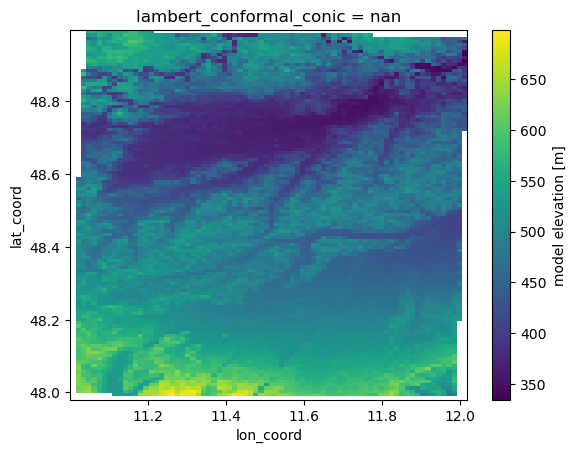

In [4]:
dem_ds['altitude'].plot()

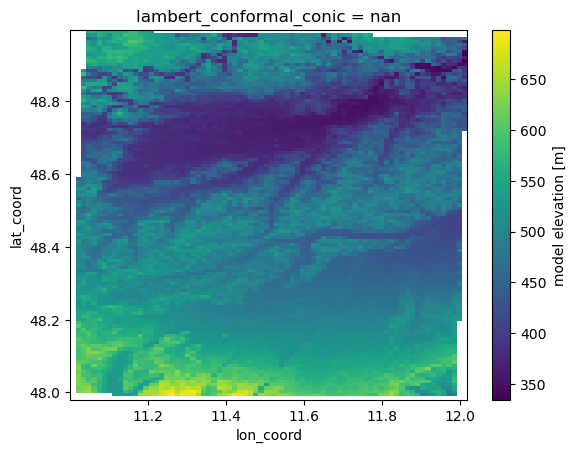

In [5]:
ref_with_alt['altitude'].plot()

In [6]:
# If your ensemble data is hourly, use something like:
ens_daily = aggregate_to_daily(ensemble_with_alt, var_name="precipitation", method="sum", compute_ens_mean=True)
# "compute_ens_mean=False" means we keep the 'member' dimension for now.

ref_daily = aggregate_to_daily(ref_with_alt, var_name="RR", method="sum")

In [7]:
print(ens_daily)

print(ref_daily)

<xarray.Dataset> Size: 3MB
Dimensions:                  (member: 10, time: 48, lat_coord: 113,
                              lon_coord: 76)
Coordinates:
  * member                   (member) object 80B '00' '01' '02' ... '08' '09'
  * time                     (time) datetime64[ns] 384B 2017-10-01 ... 2017-1...
  * lat_coord                (lat_coord) float32 452B 47.98 47.99 ... 48.99
  * lon_coord                (lon_coord) float32 304B 11.01 11.02 ... 12.0 12.01
    lambert_conformal_conic  float64 8B nan
    lat_dim                  (lat_coord) int32 452B 456500 457500 ... 568500
    lon_dim                  (lon_coord) int32 304B 226500 227500 ... 301500
    lat                      (lat_coord, lon_coord) float32 34kB nan ... 49.01
    lon                      (lat_coord, lon_coord) float32 34kB nan ... 11.99
Data variables:
    precipitation            (time, lat_coord, lon_coord) float64 3MB 0.0 ......
    altitude                 (lat_coord, lon_coord) float64 69kB nan nan ... n

In [27]:
“Add altitude binning workflow and improve daily/monthly aggregation logic”*
 - Implemented DEM-based altitude binning in `cli.py` using `bin_by_altitude`.  
 - Updated aggregation functions (`aggregate_to_daily`, etc.) to **return a Dataset** and properly reduce time steps. This resolves the mismatch of hourly vs daily time dimensions and preserves other variables like altitude.  
 - Introduced the ability to compute and plot **bias metrics** (RMSE, MAE, ME) **per altitude bin**, improving our analysis of terrain-dependent errors.  
 - Cleaned up the config-driven plotting, allowing domain-wide vs. bin-based metrics to be saved and visualized.  
 - Minor improvements to the README to reflect the new logic and usage details.


Ensemble dataset with altitude added: <xarray.Dataset> Size: 33MB
Dimensions:                  (time: 48, lat_coord: 113, lon_coord: 76,
                              member: 10)
Coordinates:
  * member                   (member) object 80B '00' '01' '02' ... '08' '09'
  * time                     (time) datetime64[ns] 384B 2017-10-01 ... 2017-1...
  * lat_coord                (lat_coord) float32 452B 47.98 47.99 ... 48.99
  * lon_coord                (lon_coord) float32 304B 11.01 11.02 ... 12.0 12.01
    lambert_conformal_conic  float64 8B nan
    lat_dim                  (lat_coord) int32 452B 456500 457500 ... 568500
    lon_dim                  (lon_coord) int32 304B 226500 227500 ... 301500
    lat                      (lat_coord, lon_coord) float32 34kB nan ... 49.01
    lon                      (lat_coord, lon_coord) float32 34kB nan ... 11.99
Data variables:
    precipitation            (time, lat_coord, lon_coord, member) float64 33MB ...
    altitude                 (lat_coo

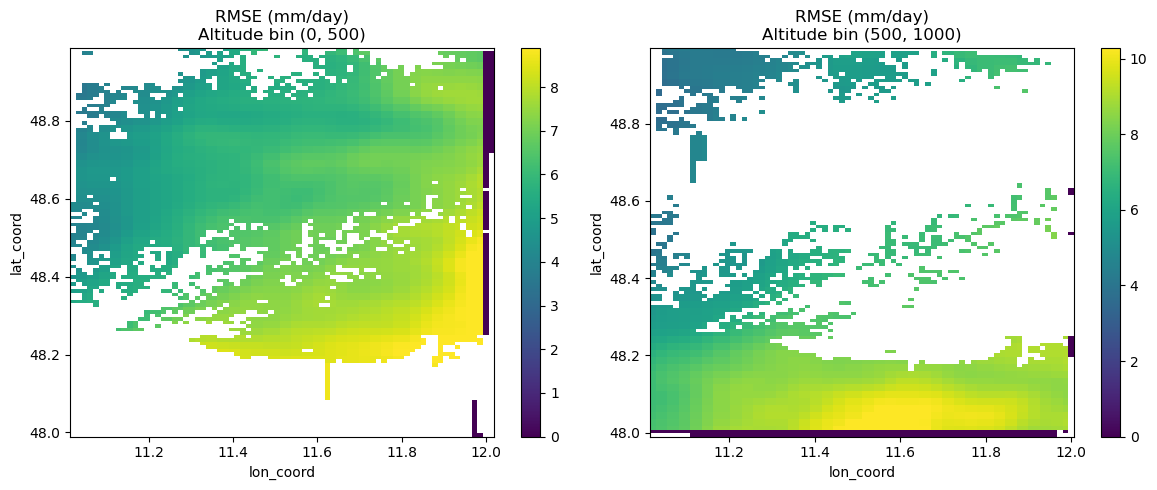

In [10]:
import matplotlib.pyplot as plt
# 4.1) Bin by altitude:
bins = [0, 500, 1000, 1500, 2000, 3000]

ens_binned = bin_by_altitude(ens_daily, alt_var="altitude", bins=bins)
ref_binned = bin_by_altitude(ref_daily, alt_var="altitude", bins=bins)

# 4.2) For each bin, compute RMSE over "time" => returns a 2D (lat_coord, lon_coord) map
rmse_maps = {}
for bin_range in bins[:-1]:
    pass  # We'll do it in a loop below

rmse_maps = {}
for i in range(len(bins) - 1):
    bin_range = (bins[i], bins[i+1])
    ens_bin = ens_binned[bin_range]
    ref_bin = ref_binned[bin_range]

    # If a bin is empty for the reference or ensemble, we skip it
    if "time" not in ens_bin.dims or "time" not in ref_bin.dims:
        # Or if alt is all NaNs in that bin, skip
        continue

    # root_mean_squared_error across time => shape = (lat_coord, lon_coord)
    rmse_map = root_mean_squared_error(
        ens_bin["precipitation"],  # ensemble variable name
        ref_bin["RR"],             # reference variable name
        dim="time"
    )

    rmse_maps[bin_range] = rmse_map

############################################
# 5) PLOT THE RMSE MAPS SIDE BY SIDE FOR TWO BINS
############################################

# Let’s say we pick two bins to plot: (0, 500) and (500, 1000)
bins_to_plot = [(0, 500), (500, 1000)]
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

for ax, bin_key in zip(axes, bins_to_plot):
    if bin_key not in rmse_maps:
        ax.set_title(f"No data for bin {bin_key}")
        continue
    
    rmse_da = rmse_maps[bin_key]
    
    # Plot with xarray's .plot() method
    im = rmse_da.plot(ax=ax, cmap="viridis", add_colorbar=False, robust=True)
    ax.set_title(f"RMSE (mm/day)\nAltitude bin {bin_key}")
    fig.colorbar(im, ax=ax, orientation="vertical")

plt.tight_layout()
plt.show()